In [1]:
import os
import pickle
import numpy as np

import matplotlib.pyplot as plt
import csv

import colorsys

In [ ]:
def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

# New color defs:
darkblue = (92/255, 128/255, 141/255)
darkred = (155/255, 54/255, 62/255)

darkgreen = (145/255, 170/255, 126/255)
darkwmgreen = (93/255, 133/255, 51/255)

newpurple = (101/255, 79/255, 167/255)
darkpurple = (176/255, 156/255, 212/255)

grey = (100/255, 100/255, 100/255)

In [3]:
log_stats_dir = "/home/gilian/Documents/Uni/UVA/master/Deep Learning 2/OpenSourceSensei/logdir/statistics"

run_sensei_gpt = {
    "name": "sensei_classic_gpt4",
    "label": "SENSEI GPT - Own",
    "color": darkblue,
}

run_sensei_llava = {
    "name": "sensei_classic_llava",
    "label": "SENSEI Llava- Own",
    "color": darkred,
}


run_rnd_baseline = {
    "name": "rnd_resnet_layernorm",
    "label": "Random Network Distillation",
    "color": grey,
}

run_p2x_christian = {
    "name": "p2x_original",
    "label": "P2X - Original",
    "color": darkwmgreen,
}

run_sensei_christian = {
    "name": "sensei_specific_original",
    "label": "SENSEI - Original",
    "color": newpurple,
}


run_sensei_general_christian = {
    "name": "sensei_general_original",
    "label": "SENSEI General - Original",
    "color": darkpurple,
}

runs = [run_sensei_gpt, run_sensei_llava, run_rnd_baseline, run_p2x_christian, run_sensei_christian, run_sensei_general_christian]

In [4]:
def get_reward_keys_dict():
    return {
        "rew_stack": [],
        "rew_upright_block_off_table": [],
        "rew_ball_off_table": [],
        "rew_flat_block_in_shelf": [],

        "rew_flat_block_off_table": [],
        "rew_ball_in_shelf": [],
        "rew_upright_block_in_shelf": [],
        
        "rew_lift_flat_block": [],
        "rew_lift_ball": [],
        "rew_lift_upright_block": [],

        "rew_flat_block_in_bin": [],
        "rew_ball_in_bin": [],
#         "rew_upright_block_in_bin": [],
        
        "rew_push_blue": [],
        "rew_push_red": [],
        "rew_push_green": [],
        "rew_open_slide": [],
#         "rew_open_slide_easy": [],
        "rew_open_drawer": [],
        "rew_open_drawer_easy": [],
#         "rew_open_drawer_medium": [],
    }

def get_interaction_keys_dict():
    return {
        "rew_interaction_drawer_joint":  [],
        "rew_interaction_slide_joint":  [],
        "rew_interaction_red_button":  [],
        "rew_interaction_green_button":  [],
        "rew_interaction_blue_button":  [],
        "rew_interaction_ball":  [],
        "rew_interaction_upright_block":  [],
        "rew_interaction_flat_block":  [],
    }

def get_interaction_labels():
    return [
        "Drawer",
        "Sliding cabinet",
        "Red Button",
        "Green button",
        "Blue button",
        "Ball",
        "Upright block",
        "Flat block",
    ]
    
def get_interaction_labels_reduced():
    return [
        "Drawer",
        "Sliding cabinet",
        "Buttons",
        "Ball",
        "Upright block",
        "Flat block",
    ]
    
def int_keys_reduced_mapper():
    return {
        "rew_interaction_drawer_joint":  0, #"Drawer",
        "rew_interaction_slide_joint":  1, #"Sliding cabinet",
        "rew_interaction_red_button":  2, #"Buttons",
        "rew_interaction_green_button":  2, #"Buttons",
        "rew_interaction_blue_button":  2, #"Buttons",
        "rew_interaction_ball":  3, #"Ball",
        "rew_interaction_upright_block":  4, #"Upright block",
        "rew_interaction_flat_block":  5, #"Flat block",
    }

In [5]:
int_keys = list(get_interaction_keys_dict().keys())
rew_keys = list(get_reward_keys_dict().keys())

int_all_mean = np.zeros((len(int_keys), len(runs)))
rew_all_mean = np.zeros((len(rew_keys), len(runs)))
int_reduced_mean = np.zeros((len(get_interaction_labels_reduced()), len(runs)))


int_all_err = np.zeros((len(int_keys), len(runs)))
rew_all_err = np.zeros((len(rew_keys), len(runs)))
int_reduced_err = np.zeros((len(get_interaction_labels_reduced()), len(runs)))

length_all = np.zeros((len(runs), 3))

In [6]:
rew_all_mean.shape

(18, 6)

In [7]:
relative = False

reduced_labels = get_interaction_labels_reduced()
reduced_labels_mapper = int_keys_reduced_mapper()


for run_i, run in enumerate(runs):
    run_name = run["name"]        

    button_tracker = 0
    with open(os.path.join(log_stats_dir, f'statistics_{run_name}.pickle'), 'rb') as handle:
        run_statistics = pickle.load(handle)

    for key_i, key in enumerate(int_keys):            
        if relative and run_name != "rnd_resnet_layernorm":
            seeds = np.array([run_statistics[0][key]/run_statistics[0]['total_length']
                              ,
                              run_statistics[1][key]/run_statistics[1]['total_length']
                            ,
                              run_statistics[2][key]/run_statistics[2]['total_length']
                              ])
        elif run_name == "rnd_resnet_layernorm":
          seeds = np.array([run_statistics[0][key]/4
                            ,
                            run_statistics[1][key]/4
                          ,
                            run_statistics[2][key]/4
                            ])
        else:
            seeds = np.array([
                              run_statistics[0][key]
                              ,
                              run_statistics[1][key]
                            ,
                              run_statistics[2][key]
                              ])

        int_all_mean[key_i, run_i] = seeds.mean()
        int_all_err[key_i, run_i] = seeds.std()
            
        if "button" in key:
            if button_tracker == 0:
                button_seeds = seeds
            else:
                button_seeds = button_seeds + seeds
            button_tracker += 1
            
            if button_tracker == 3:
                reduced_key_i = reduced_labels_mapper[key]
                int_reduced_mean[reduced_key_i, run_i] = button_seeds.mean()
                int_reduced_err[reduced_key_i, run_i] = button_seeds.std()
        else:
            reduced_key_i = reduced_labels_mapper[key]
            int_reduced_mean[reduced_key_i, run_i] = seeds.mean()
            int_reduced_err[reduced_key_i, run_i] = seeds.std()

    length_all[run_i, 0] = run_statistics[0]['total_length']
    length_all[run_i, 1] = run_statistics[1]['total_length']
    length_all[run_i, 2] = run_statistics[2]['total_length']

    for key_i, key in enumerate(rew_keys):
        if relative and run_name != "rnd_resnet_layernorm":
            seeds = np.array([run_statistics[0][key]/run_statistics[0]['total_length']
                              ,
                              run_statistics[1][key]/run_statistics[1]['total_length']
                            ,
                              run_statistics[2][key]/run_statistics[2]['total_length']
                              ])
        elif run_name == "rnd_resnet_layernorm":
            seeds = np.array([run_statistics[0][key]/4
                              ,
                              run_statistics[1][key]/4
                            ,
                              run_statistics[2][key]/4
                              ])
        else:
            seeds = np.array([run_statistics[0][key]
                              ,
                              run_statistics[1][key]
                            ,
                              run_statistics[2][key]
                              ])
        rew_all_mean[key_i, run_i] = seeds.mean()
        rew_all_err[key_i, run_i] = seeds.std()

In [8]:
savefig = False
if savefig:
    fig_path = "eval_figures_robodesk_interactions" 

    os.makedirs(fig_path, exist_ok=True)

<Figure size 1700x550 with 0 Axes>

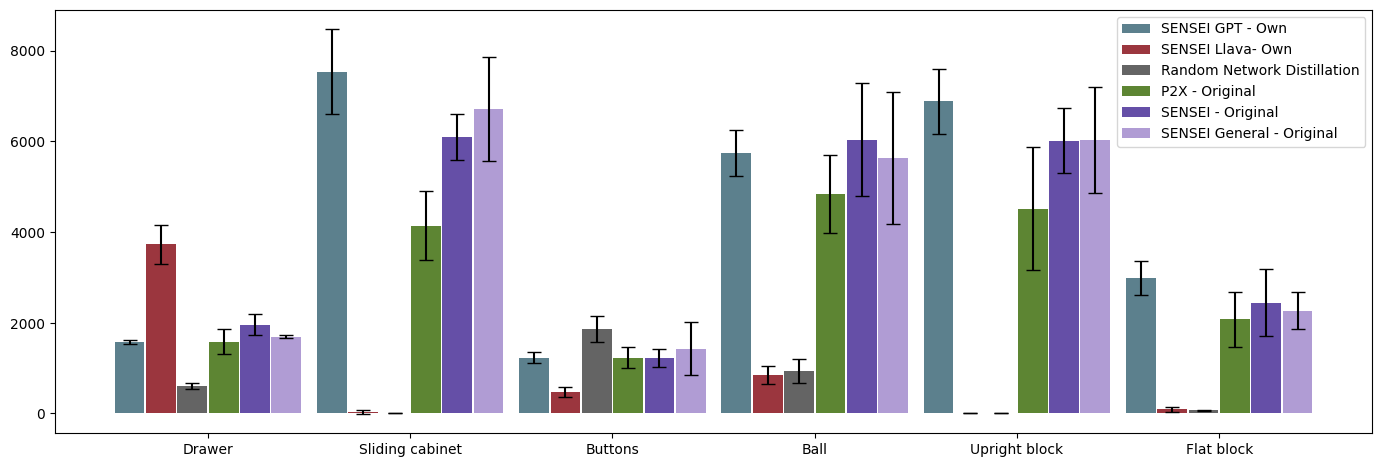

In [9]:
categories = get_interaction_labels_reduced()
methods = [run["name"] for run in runs]
data = int_reduced_mean

# Error values for each method in each category
errors = int_reduced_err

num_categories = len(categories)
num_methods = len(methods)

# Setting the positions of the bars
bar_width = 0.2
gap = 0.02
category_positions = np.arange(num_categories)

# Settings for the figure
fig_width = 17  # increase figure width
fig_height = 5.5
plt.figure(figsize=(fig_width, fig_height))

# Setting the positions of the bars
bar_width = 0.5
gap = 0.027  # gap between bars within the same category
category_gap = 3.4  # increase gap between categories
category_positions = np.arange(num_categories) * category_gap

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
for i in range(num_methods):
    method_positions = category_positions - (num_methods / 2.0 - i - 0.5) * (bar_width + gap)
    ax.bar(method_positions, data[:, i], width=bar_width, yerr=errors[:, i], capsize=5, label=runs[i]["label"],
           color=runs[i]["color"])

# Adding labels and title
# ax.set_xlabel('Entities')
# ax.set_ylabel('Interaction counts')
ax.set_xticks(category_positions)
ax.set_xticklabels(categories)
ax.set_xticklabels(get_interaction_labels_reduced())

ax.legend()

# ax.set_title('Interaction Statistics Across Entities')

if savefig:
    fig.savefig(os.path.join(fig_path, "raw_interaction_stats_winners_onefig.png"), dpi=600, bbox_inches="tight")

<Figure size 1200x550 with 0 Axes>

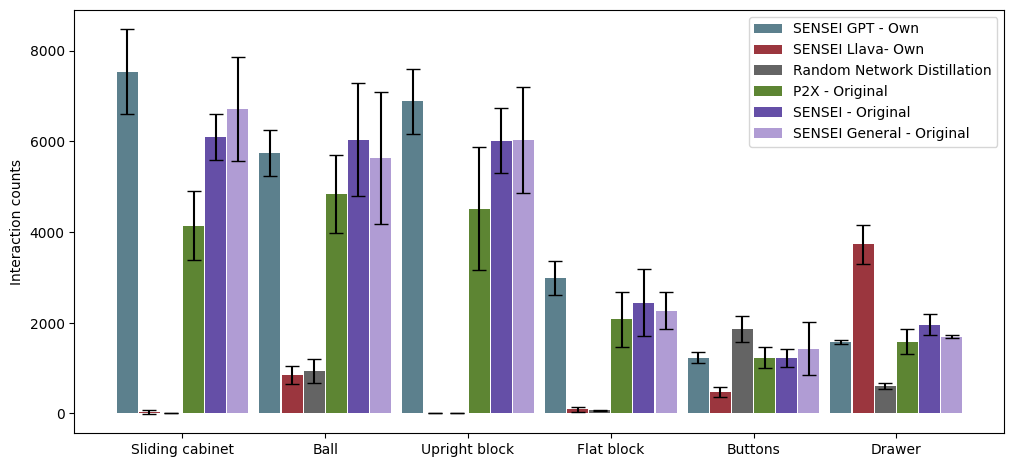

In [ ]:
categories = get_interaction_labels_reduced()
new_category_order = [1,3,4,5,2, 0]

categories = [categories[i] for i in new_category_order]
methods = [run["name"] for run in runs]
data = int_reduced_mean[new_category_order,:]

# Error values for each method in each category
errors = int_reduced_err[new_category_order,:]

num_categories = len(categories)
num_methods = len(methods)

# Setting the positions of the bars
bar_width = 0.2
gap = 0.02
category_positions = np.arange(num_categories)

# Settings for the figure
fig_width = 12  # increase figure width
fig_height = 5.5
plt.figure(figsize=(fig_width, fig_height))

# Setting the positions of the bars
bar_width = 0.5
gap = 0.027  # gap between bars within the same category
category_gap = 3.4  # increase gap between categories
category_positions = np.arange(num_categories) * category_gap

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
for i in range(num_methods):
    method_positions = category_positions - (num_methods / 2.0 - i - 0.5) * (bar_width + gap)
    ax.bar(method_positions, data[:, i], width=bar_width, yerr=errors[:, i], capsize=5, label=runs[i]["label"],
           color=runs[i]["color"])

# Adding labels and title
# ax.set_xlabel('Entities')
ax.set_ylabel('Interaction counts')
ax.set_xticks(category_positions)
ax.set_xticklabels(categories)

ax.legend()

# Show the plot
# plt.show()

if savefig:
    fig.savefig(os.path.join(fig_path, "raw_interaction_stats_winners_onefig_reordered.png"), dpi=600, bbox_inches="tight")

In [12]:
categories

['Sliding cabinet', 'Ball', 'Upright block', 'Flat block', 'Buttons', 'Drawer']

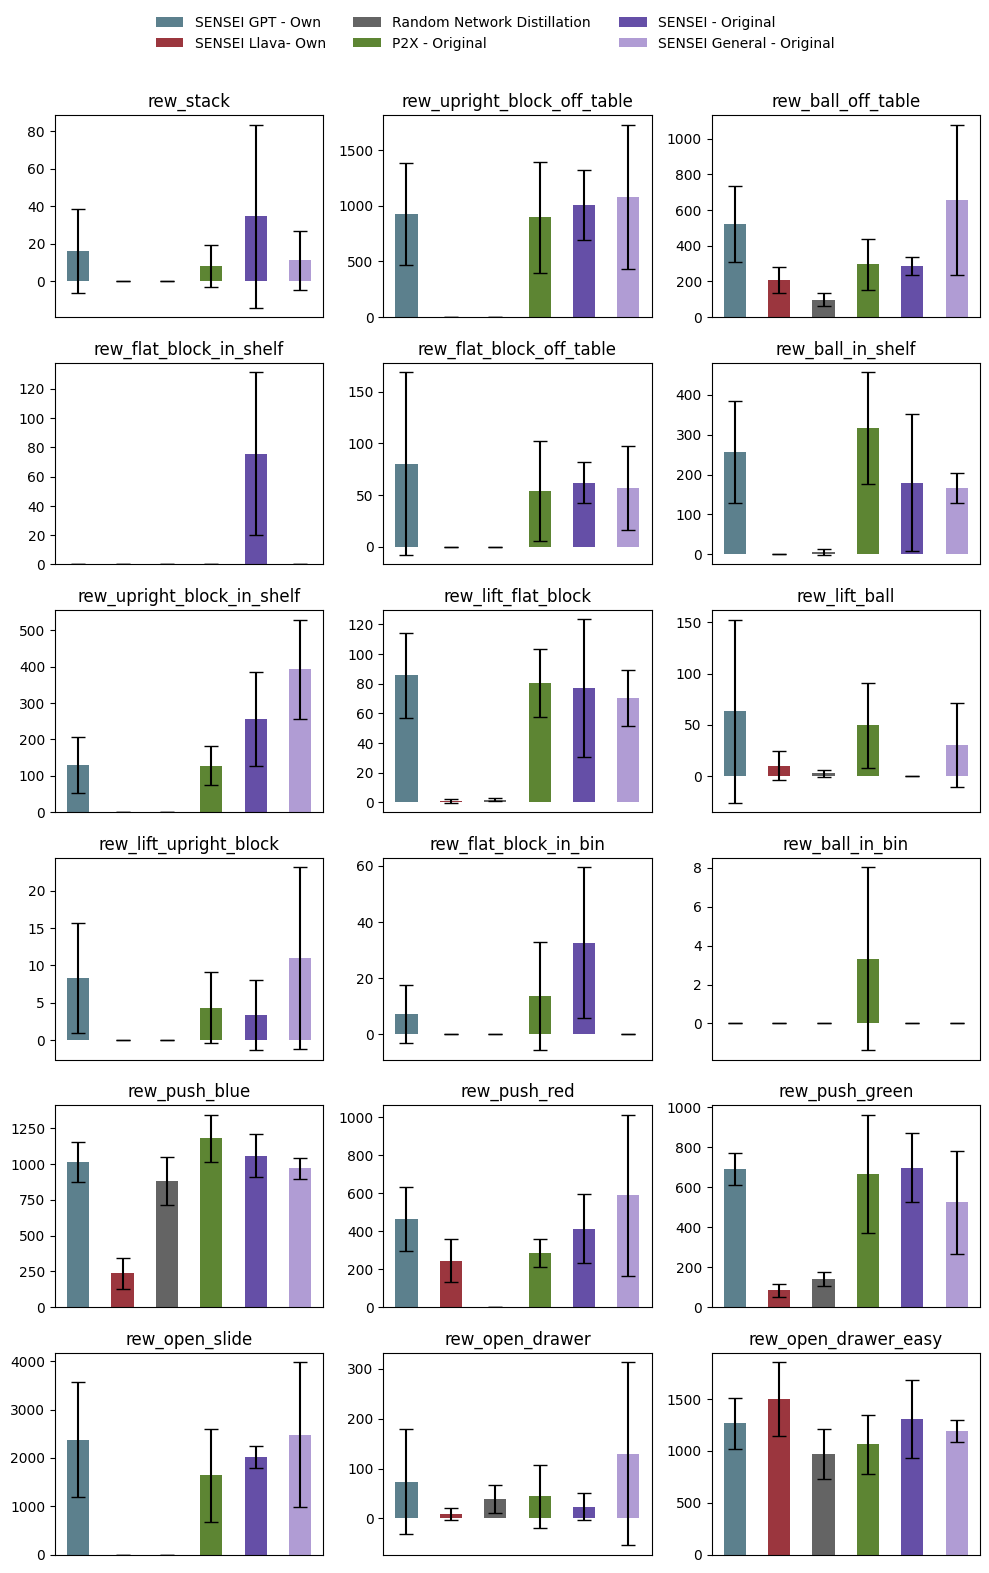

In [ ]:
# Sample data
categories = [key for key in rew_keys]

methods = [run["name"] for run in runs]
data = rew_all_mean

# Error values for each method in each category
errors = rew_all_err

num_categories = len(categories)
num_methods = len(methods)

# Settings for the figure
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 15))  # Adjust layout to fit 8 plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

bar_width = 0.1
gap = 0.2  # Smaller gap within each category

for i, ax in enumerate(axes):
    category_positions = np.arange(num_methods) * gap
    for j in range(num_methods):
        ax.bar(category_positions[j] - bar_width, data[i, j], width=bar_width, 
               yerr=errors[i, j], capsize=5, label=runs[j]["label"],
           color=runs[j]["color"])
        
    ax.set_title(categories[i])
    ax.set_xticklabels("")
    ax.set_xticks([])

# # Adjust subplots to fit the legend below
fig.subplots_adjust(bottom=0.2, top=0.95)
# # Add a common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           fancybox=True, shadow=False, ncol=3, frameon=False)

plt.tight_layout()
# plt.show()

if savefig:
    fig.savefig(os.path.join(fig_path, "raw_reward_stats_.png"), dpi=600, bbox_inches="tight")
    tikzplotlib.save(os.path.join(fig_path, "raw_reward_counts_grid.tex"))

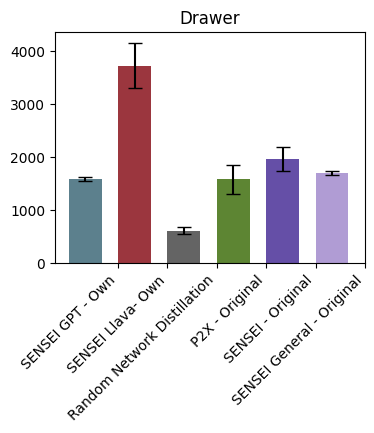

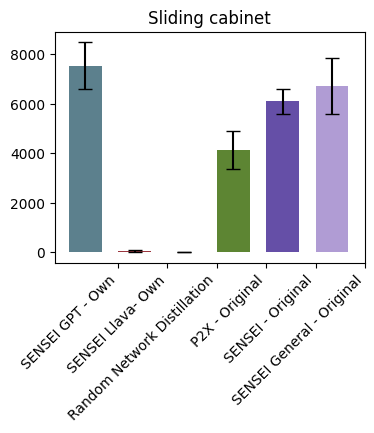

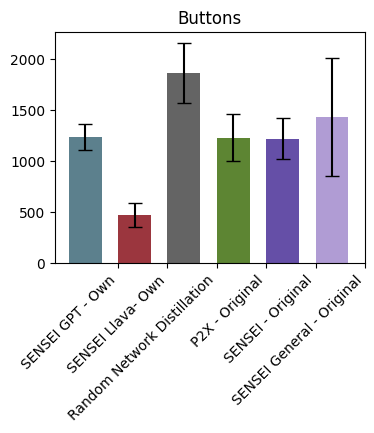

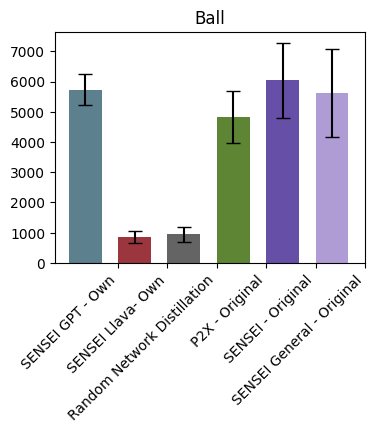

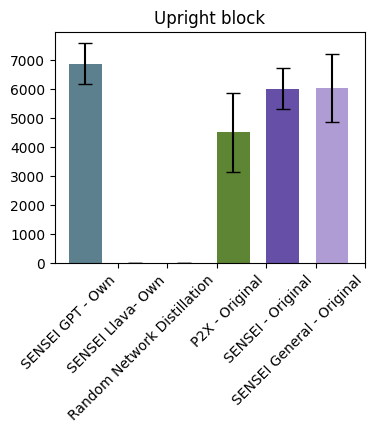

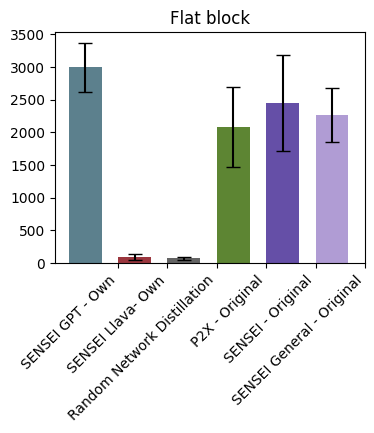

In [ ]:
# Sample data
categories = get_interaction_labels_reduced()
methods = [run["name"] for run in runs]
data = int_reduced_mean

# Error values for each method in each category
errors = int_reduced_err

num_categories = len(categories)
num_methods = len(methods)

# Settings for the figure
bar_width = 0.3
gap = 0.45  # Smaller gap within each category

for i in range(num_categories):
    category_positions = np.arange(num_methods)
    fig, ax = plt.subplots(figsize=(4, 3))
    
    category_positions = np.arange(num_methods)*gap
    for j in range(num_methods):
        ax.bar(category_positions[j] - bar_width, data[i, j], width=bar_width, 
               yerr=errors[i, j], capsize=5, label=runs[j]["label"],
           color=runs[j]["color"])
        
    ax.set_xticks(category_positions)
    ax.set_xticklabels([run["label"] for run in runs], rotation=45, ha="right")
    ax.set_title(categories[i])
    # ax.set_xticklabels("")
    # ax.set_xticks([])
    # ax.set_ylim(0, 50)  # Adjust as needed based on your data range
    if savefig:
        name = categories[i]
        fig.savefig(os.path.join(fig_path, f"raw_interactions_{name}.png"), dpi=600, bbox_inches="tight")